In [25]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows
import pandas as pd

import pyworld
import pysptk
import nnmnkwii
import matplotlib.pyplot as plt

In [26]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    bap = pyworld.code_aperiodicity(aperiodicity, fs)
    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))
    f0 = f0[:, None]
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")
    
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")

    lf0 = lf0.reshape(lf0.shape[0],1)
    vuv = vuv.reshape(vuv.shape[0],1)

    mgc_delta = apply_delta_windows(mgc, windows)
    lf0_delta = apply_delta_windows(lf0, windows)
    bap_delta = apply_delta_windows(bap, windows)
    
    features = np.hstack((mgc, lf0, vuv, bap))

    delta_features = np.hstack((mgc_delta, lf0_delta, vuv, bap_delta))
    
    return features, delta_features


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()

In [13]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'SDTL' # ENF or ENM or SDTL
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['DN004', 'DN011', 'DN006', 'DN008', 'DN009', 'DN005', 'DN007', 'DN010']


In [147]:
sub_name = 'DN011'

data_sub_folder = os.path.join(group_folder, sub_name)

WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
WAV_path_list = glob.glob(WAV_path_list)
WAV_path_list.sort()

EMA_path_list = os.path.join(data_sub_folder, '*' + '.MV8')
EMA_path_list = glob.glob(EMA_path_list)
EMA_path_list.sort()

print(len(EMA_path_list))

264


In [148]:
MV = np.genfromtxt(EMA_path_list[1], skip_header=1, skip_footer=1)

In [149]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

file_num = len(WAV_path_list)

train_index = [range(0, 122), range(132, 254)]
valid_index = [range(122, 127),  range(254, 259)]
test_index = [range(127, 132), range(259, 264)]

train_index = [i for j in (range(0, 122), range(132, 254)) for i in j]
valid_index = [i for j in (range(122, 127), range(254, 259)) for i in j]
test_index = [i for j in (range(127, 132), range(259, 264)) for i in j]

print(len(train_index))
print(len(valid_index))
print(len(test_index))

244
10
10


In [150]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1  

In [151]:
Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1 

In [152]:
Train_MV = {}
Train_WAV = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV[index] = MV_delta
  Train_WAV[index] = WAV_delta
  
  index = index + 1 

In [153]:
Train_MV_block = np.concatenate([Train_MV[x] for x in Train_MV], 0).astype(np.float32)
Train_WAV_block = np.concatenate([Train_WAV[x] for x in Train_WAV], 0)

Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [154]:
print(Train_MV_block.shape)
print(Train_WAV_block.shape)

(110672, 24)
(110672, 127)


In [155]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [156]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(512, activation = tf.nn.relu, input_shape = (Train_MV_block.shape[1],)),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(Train_WAV_block.shape[1])
    ])
    
    optimizer = tf.keras.optimizers.SGD(0.002)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 512)               12800     
_________________________________________________________________
dense_97 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_98 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_99 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_100 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_101 (Dense)            (None, 127)               65151     
Total params: 1,128,575
Trainable params: 1,128,575
Non-trainable params: 0
_________________________________________________________________


 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

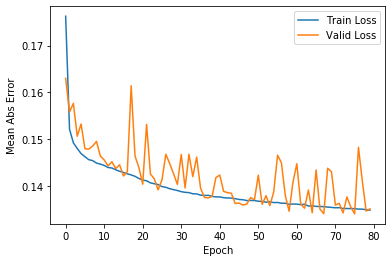

In [157]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
EPOCHS = 80

history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = EPOCHS, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [early_stop, PrintDot()])
plot_history(history)

In [158]:
test_predictions = model.predict(Test_MV_block)

In [159]:
mgc_head = test_predictions[:, 0:mgc_dim]
lf0_head = test_predictions[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_head = test_predictions[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_head = test_predictions[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]


mgc_ref = Test_WAV_block[:, 0:mgc_dim]
lf0_ref = Test_WAV_block[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_ref = Test_WAV_block[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_ref = Test_WAV_block[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]

In [160]:
f0 = lf0_head.copy()
f0[vuv_head < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

spectrogram = pysptk.mc2sp(mgc_head, fftlen=fftlen, alpha=alpha)
aperiodicity = pyworld.decode_aperiodicity(bap_head.astype(np.float64), fs, fftlen)

generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        fs, frame_period)
Audio(generated_waveform.astype(np.float64), rate = fs)

In [161]:
def compute_mse(ref_data, gen_data):
    diff = (ref_data - gen_data) ** 2
    sum_diff = np.sum(diff, axis=1)
    sum_diff = np.sqrt(sum_diff)       # ** 0.5
    sum_diff = np.sum(sum_diff, axis=0)

    return  sum_diff
  
def compute_f0_mse(ref_data, gen_data):
  ref_vuv_vector = np.zeros((ref_data.size, 1))
  gen_vuv_vector = np.zeros((ref_data.size, 1))

  ref_vuv_vector[ref_data > 0.0] = 1.0
  gen_vuv_vector[gen_data > 0.0] = 1.0

  sum_ref_gen_vector = ref_vuv_vector + gen_vuv_vector
  voiced_ref_data = ref_data[sum_ref_gen_vector == 2.0]
  voiced_gen_data = gen_data[sum_ref_gen_vector == 2.0]
  voiced_frame_number = voiced_gen_data.size

  f0_mse = np.sum(((np.exp(voiced_ref_data) - np.exp(voiced_gen_data)) ** 2))
#        f0_mse = numpy.sum((((voiced_ref_data) - (voiced_gen_data)) ** 2))

  vuv_error_vector = sum_ref_gen_vector[sum_ref_gen_vector == 0.0]
  vuv_error = np.sum(sum_ref_gen_vector[sum_ref_gen_vector == 1.0])

  return  f0_mse, vuv_error, voiced_frame_number

from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)

bap_mse = compute_mse(bap_head, bap_ref) / bap_ref.shape[0]

BAP = bap_mse /10

f0_mse, vuverror, voiced_frame_number = compute_f0_mse(lf0_head, lf0_ref)

f0_RMSE = np.sqrt( f0_mse / lf0_ref.shape[0] )

vuv_head[vuv_head >= 0.5] = 1
vuv_head[vuv_head < 0.5] = 0

error_count = vuv_head + vuv_ref


error_num = np.count_nonzero(error_count == 1)
VUV = error_num / vuv_ref.shape[0]

print(MCD)
print(BAP)
print(f0_RMSE)
print(VUV)

6.600977581444467
0.37627077618194366
22.945789205710074
0.26691919191919194
